In [22]:
import os
import sys
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from joblib import Parallel, delayed

cwd = os.getcwd()
model_path = os.path.abspath(os.path.join(cwd, os.pardir, 'models'))
sys.path.append(model_path)
from cumul_diamond_ODE_model import *
from cumul_treated_diamond_ODE_model import *

In [23]:
untreated_model = cumulDiamondODEModel()
treated_model = cumulTreatedDiamondODEModel()
times = np.linspace(0,31,500)
n_simulations = 100
nu = 2 / 4.3
inferred_parameters = pd.read_csv('../data/inferred_parameters.csv')
data = pd.read_csv('../data/data_cases_symp.csv')
data['onset_date'] = pd.to_datetime(data['onset_date'], format='%d-%b')
all_untreated_passengers = []
all_untreated_crew = []

for _ in range(n_simulations):
    idx = np.random.randint(0, inferred_parameters.shape[0])
    selected_params = inferred_parameters.iloc[idx].to_list()
    untreated_values = untreated_model.simulate(selected_params[:8], times)
    cumul_infected_passengers = untreated_values[-1,22]
    cumul_infected_crew = untreated_values[-1,23]

    all_untreated_passengers.append(cumul_infected_passengers)
    all_untreated_crew.append(cumul_infected_crew)

all_untreated_passengers = np.array(all_untreated_passengers)
all_untreated_crew = np.array(all_untreated_crew)
mean_passengers = np.mean(all_untreated_passengers, axis=0)
mean_crew = np.mean(all_untreated_crew, axis=0)

/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_diamond_ODE_model.py:67: RuntimeWarning: overflow encountered in exp
  bcp = (bbarcp + a2) * ccp * (1 - b1 / (1 + np.exp(-b2 * (t - tcp - a))))
/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_diamond_ODE_model.py:68: RuntimeWarning: overflow encountered in exp
  bcc = (bbarcc + a2) * ccc * (1 - b1 / (1 + np.exp(-b2 * (t - tcc - a))))
/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_diamond_ODE_model.py:69: RuntimeWarning: overflow encountered in exp
  bpc = (bbarpc + a2) * cpc * (1 - b1 / (1 + np.exp(-b2 * (t - tpc - a))))
/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_diamond_ODE_model.py:70: RuntimeWarning: overflow encountered in exp
  bpp = (bbarpp + a2) * cpp * (1 - b1 / (1 + np.exp(-b2 * (t - tpp - a))))


In [26]:
coverage_array = np.linspace(0, 1, 50)
efficacy_array = np.linspace(0, 1, 50)

# Sample parameter sets in advance
sampled_indices = np.random.randint(0, inferred_parameters.shape[0], size=n_simulations)
sampled_parameters = [inferred_parameters.iloc[idx].to_list() for idx in sampled_indices]

def simulate_model(eff, pint, sampled_parameters, nu, times):
    all_treated_passengers = []
    all_treated_crew = []
    for params in sampled_parameters:
        treated_values = treated_model.simulate(params[:8] + [eff, eff, pint, pint], times)
        
        cumul_infected_treated_passengers = treated_values[-1,22]
        cumul_infected_treated_crew = treated_values[-1,23]

        all_treated_passengers.append(cumul_infected_treated_passengers)
        all_treated_crew.append(cumul_infected_treated_crew)
    
    mean_treated_passengers = np.mean(all_treated_passengers)
    mean_treated_crew = np.mean(all_treated_crew)
    return eff, pint, mean_treated_passengers, mean_treated_crew


# Prepare inputs for parallel processing
task_inputs = [(eff, pint, sampled_parameters, nu, times, n_simulations) 
               for eff in efficacy_array 
               for pint in coverage_array]

# Execute simulations in parallel
results = Parallel(n_jobs=-1)(delayed(simulate_model)(eff, pint, sampled_parameters, nu, times) for eff in efficacy_array for pint in coverage_array)


# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=["Efficacy", "Coverage", "Mean Infected Passengers", "Mean Infected Crew"])


/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_treated_diamond_ODE_model.py:82: RuntimeWarning: overflow encountered in exp
  bcp = (bbarcp + a2) * ccp * (1 - b1 / (1 + np.exp(-b2 * (t - tcp - a))))
/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_treated_diamond_ODE_model.py:83: RuntimeWarning: overflow encountered in exp
  bcc = (bbarcc + a2) * ccc * (1 - b1 / (1 + np.exp(-b2 * (t - tcc - a))))
/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_treated_diamond_ODE_model.py:84: RuntimeWarning: overflow encountered in exp
  bpc = (bbarpc + a2) * cpc * (1 - b1 / (1 + np.exp(-b2 * (t - tpc - a))))
/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_treated_diamond_ODE_model.py:85: RuntimeWarning: overflow encountered in exp
  bpp = (bbarpp + a2) * cpp * (1 - b1 / (1 + np.exp(-b2 * (t - tpp - a))))
/Users/george/Documents/Imperial:LL/Closed Population/Diamond/models/cumul_treated_diamond_O

In [27]:
results_df.to_csv('../data/newcombined_coverage_efficacy_sensitivity_analysis.csv')
results_df

,Efficacy,Coverage,Mean Infected Passengers,Mean Infected Crew
0,0.0,0.000000,1108.927090,488.002695
1,0.0,0.020408,1108.927090,488.002697
2,0.0,0.040816,1108.927090,488.002697
3,0.0,0.061224,1108.927090,488.002695
4,0.0,0.081633,1108.927090,488.002698
...,...,...,...,...
2495,1.0,0.918367,1.229712,0.086276
2496,1.0,0.938776,0.782759,0.048555
2497,1.0,0.959184,0.440914,0.023920
2498,1.0,0.979592,0.184693,0.008700


In [28]:
df = pd.read_csv('../data/newcombined_coverage_efficacy_sensitivity_analysis.csv')
filtered_df = df.loc[(df['Coverage'] == 0)]
total_untreated_infections = filtered_df.loc[filtered_df.index[0], 'Mean Infected Passengers'] + filtered_df.loc[filtered_df.index[0], 'Mean Infected Crew']
df['Percentage Averted'] = 1 - (df['Mean Infected Passengers'] + df['Mean Infected Crew'])/total_untreated_infections
df['Total infections averted'] = total_untreated_infections - (df['Mean Infected Passengers'] + df['Mean Infected Crew'])
df


,Unnamed: 0,Efficacy,Coverage,Mean Infected Passengers,Mean Infected Crew,Percentage Averted,Total infections averted
0,0,0.0,0.000000,1108.927090,488.002695,0.000000e+00,0.000000e+00
1,1,0.0,0.020408,1108.927090,488.002697,-1.541636e-09,-2.461884e-06
2,2,0.0,0.040816,1108.927090,488.002697,-1.208064e-09,-1.929193e-06
3,3,0.0,0.061224,1108.927090,488.002695,-2.804472e-10,-4.478545e-07
4,4,0.0,0.081633,1108.927090,488.002698,-1.838497e-09,-2.935951e-06
...,...,...,...,...,...,...,...
2495,2495,1.0,0.918367,1.229712,0.086276,9.991759e-01,1.595614e+03
2496,2496,1.0,0.938776,0.782759,0.048555,9.994794e-01,1.596098e+03
2497,2497,1.0,0.959184,0.440914,0.023920,9.997089e-01,1.596465e+03
2498,2498,1.0,0.979592,0.184693,0.008700,9.998789e-01,1.596736e+03


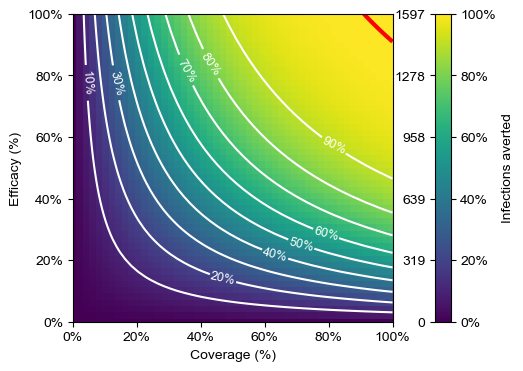

In [29]:
efficacy_values = np.sort(df['Efficacy'].unique())
coverage_values = np.sort(df['Coverage'].unique())

cmap = plt.get_cmap('viridis')
plt.rcParams['font.family'] = 'Arial'

# Converting to percentage for consistency
min_averted = df['Percentage Averted'].min() * 100
max_averted = df['Percentage Averted'].max() * 100

# Creating a mapping based on the actual min and max in the data
min_total_averted = df['Total infections averted'].min()
max_total_averted = df['Total infections averted'].max()

def map_percentage_to_total(percentage, min_percentage, max_percentage, min_total, max_total):
    return np.abs(min_total + (max_total - min_total) * ((percentage - min_percentage) / (max_percentage - min_percentage)))

fig, ax = plt.subplots(figsize=(5.5,4))

averted_grid = np.zeros((len(coverage_values), len(efficacy_values)))
for j, efficacy in enumerate(efficacy_values):
    for k, cov in enumerate(coverage_values):
        df_specific = df[(df['Coverage'] == cov) & (df['Efficacy'] == efficacy)]
        percentage_averted = df_specific['Percentage Averted'].values
        averted_grid[k, j] = percentage_averted[0] * 100 if percentage_averted.size > 0 else np.nan

mesh = ax.pcolormesh(coverage_values * 100, efficacy_values * 100, averted_grid, cmap=cmap, shading='auto', vmin=min_averted, vmax=max_averted)
CS = ax.contour(coverage_values * 100, efficacy_values * 100, averted_grid, colors='white', levels=np.arange(10, 101, 10))
herd_immunity=ax.contour(coverage_values*100, efficacy_values*100, averted_grid, colors='red', levels=[100*0.999], linewidths=3)
ax.clabel(CS, inline=True, fontsize=9, fmt='%1.0f%%')
ax.clabel(herd_immunity, inline=True, fontsize=11, fmt='%1.0f%%')

ax.set_xlabel('Coverage (%)')
ax.set_ylabel('Efficacy (%)')
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.xaxis.set_major_formatter(mticker.PercentFormatter())
ax.yaxis.set_major_formatter(mticker.PercentFormatter())

# Main colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', pad=0.10)
cbar.ax.set_ylabel('Infections averted')
cbar.ax.yaxis.set_major_formatter(mticker.PercentFormatter())

# Define custom tick positions for the colorbar (from 0% to 100%)
ticks = np.linspace(0, 100, num=6)  # For example, 11 ticks from 0% to 100%

# Apply the custom ticks to the colorbar
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{tick:.0f}%" for tick in ticks])  # Update tick labels to reflect the new tick positions

# Generate labels for 'Total infections averted' based on the custom ticks
total_infections_averted_labels = [f"{map_percentage_to_total(x, 0, 100, min_total_averted, max_total_averted):.0f}" for x in ticks]

# Create the secondary axis for the total infections averted
cax = cbar.ax.figure.add_axes(cbar.ax.get_position())
cax.patch.set_alpha(0)  # Make the new axes background transparent
cax.yaxis.tick_left()
cax.yaxis.set_label_position('left')
cax.xaxis.set_visible(False)
cax.set_yticks(ticks)  # Use the same tick positions as the main colorbar
cax.set_yticklabels(total_infections_averted_labels, ha='right')
cax.set_frame_on(False)  # Turn off the frame to avoid overlapping the colorbar

# Define the directory path and the filename
directory = '../figures'
filename = 'figure3b.svg'

# Check if the directory exists
if not os.path.exists(directory):
    # If the directory does not exist, create it
    os.makedirs(directory)

# Save the figure
plt.savefig(os.path.join(directory, filename), bbox_inches='tight')

plt.show()